### Import Files ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import pickle
import time

## Dataset Directory ##

In [3]:
DATADIR= "/kaggle/input/dataset/Dataset"
CATEGORIES=["Fire","Non-Fire"]
#going to iterate through the two categories
for category in CATEGORIES:
    path= os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array= cv2.imread(os.path.join(path,img)) 
        break
    break

# Find the size of the Image #

In [4]:
print(img_array.shape)

(599, 976, 3)


# Resize the Image #

In [5]:
IMG_SIZE= 228
new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

In [6]:
new_array.shape

(228, 228, 3)

# Create Training Data #

In [7]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path= os.path.join(DATADIR,category)#path to dataset
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array= cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass

create_training_data()

# Shuffle the Training Data #

In [8]:
import random
random.shuffle(training_data)

# Check Train Sample Detections #

In [9]:
for sample in training_data[:10]:
    if sample[1]==0:
        print ('Fire Satellite Image')
    else:
        print('Non-Fire Satellite Image')

Non-Fire Satellite Image
Fire Satellite Image
Fire Satellite Image
Non-Fire Satellite Image
Fire Satellite Image
Fire Satellite Image
Non-Fire Satellite Image
Fire Satellite Image
Fire Satellite Image
Fire Satellite Image


# Preparation for Training #

In [10]:
X_calamity=[]#features
y_calamity=[]#labels

In [11]:
for features, label in training_data:
    X_calamity.append(features)
    y_calamity.append(label)
    
X_calamity= np.array(X_calamity).reshape(-3,IMG_SIZE,IMG_SIZE,3)

In [12]:
X_calamity[0].shape

(228, 228, 3)

In [13]:
# Batch Normalisation
X_calamity=X_calamity/255.0 

In [14]:
X_calamity.shape[1:]

(228, 228, 3)

# Custom Model #

In [15]:
model = Sequential()
#First Convulational layer
model.add(Conv2D(kernel_size=3, strides=1, filters=256,input_shape=X_calamity.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
#Second Convulational layer
model.add(Conv2D(kernel_size=3, strides=1, filters=128, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=(2,2)))
#third Convulational layer
model.add(Conv2D(kernel_size=3, strides=1, filters=64, padding='same',
                 activation='relu', name='layer_conv3'))
model.add(MaxPooling2D(pool_size=(2,2)))
#drop-out layer 
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=2, strides=2))
#fourth Convulational layer
model.add(Conv2D(kernel_size=3, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv4'))
model.add(MaxPooling2D(pool_size=(2,2)))
#fifth Convulational layer
model.add(Conv2D(kernel_size=3, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv5'))
model.add(MaxPooling2D(pool_size=(2,2)))
#sixth Convulational layer
model.add(Conv2D(kernel_size=3, strides=1, filters=8, padding='same',
                 activation='relu', name='layer_conv6'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))

#output layer 
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=['accuracy']) #Default LR=0.001

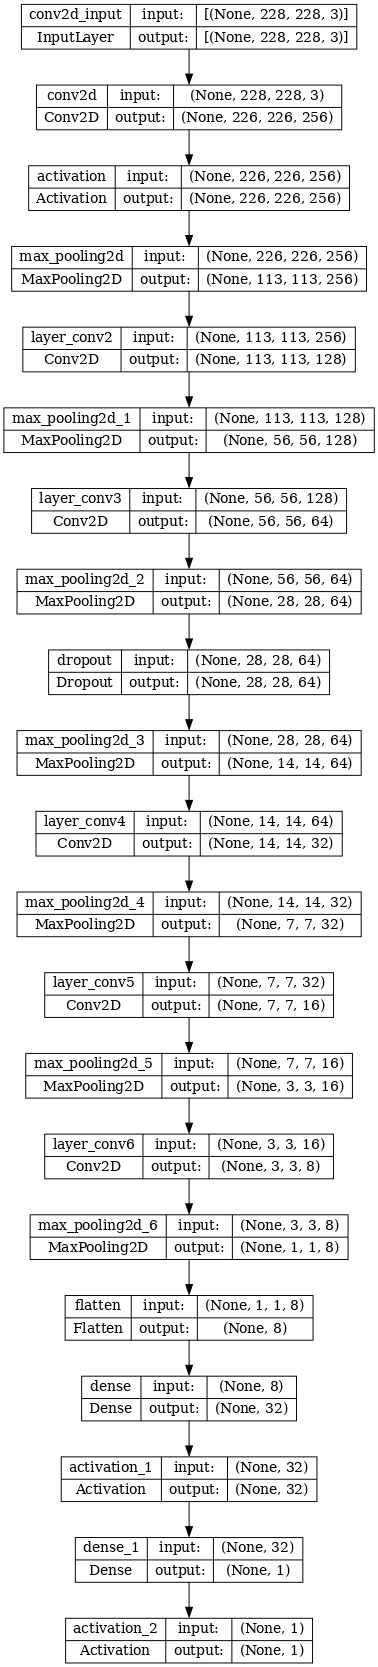

In [16]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [17]:
y_calamity=np.array(y_calamity)
X_calamity=np.array(X_calamity)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 256)     7168      
                                                                 
 activation (Activation)     (None, 226, 226, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 256)    0         
 )                                                               
                                                                 
 layer_conv2 (Conv2D)        (None, 113, 113, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 layer_conv3 (Conv2D)        (None, 56, 56, 64)        7

### Training of the Model ###

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=0)
#Results 
history=model.fit(X_calamity,y_calamity,batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100


2023-04-06 19:42:49.601667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


8/8 [==============================] - 16s 682ms/step - loss: 0.6945 - accuracy: 0.5363 - val_loss: 0.6968 - val_accuracy: 0.4643
Epoch 2/100
8/8 [==============================] - 2s 272ms/step - loss: 0.6862 - accuracy: 0.5363 - val_loss: 0.6972 - val_accuracy: 0.4643
Epoch 3/100
8/8 [==============================] - 2s 274ms/step - loss: 0.6790 - accuracy: 0.5444 - val_loss: 0.6956 - val_accuracy: 0.4643
Epoch 4/100
8/8 [==============================] - 2s 274ms/step - loss: 0.6457 - accuracy: 0.6734 - val_loss: 0.6304 - val_accuracy: 0.7143
Epoch 5/100
8/8 [==============================] - 2s 273ms/step - loss: 0.6693 - accuracy: 0.6613 - val_loss: 0.6819 - val_accuracy: 0.5714
Epoch 6/100
8/8 [==============================] - 2s 268ms/step - loss: 0.6439 - accuracy: 0.6250 - val_loss: 0.7009 - val_accuracy: 0.4286
Epoch 7/100
8/8 [==============================] - 2s 264ms/step - loss: 0.6360 - accuracy: 0.6452 - val_loss: 0.6780 - val_accuracy: 0.7143
Epoch 8/100
8/8 [=======

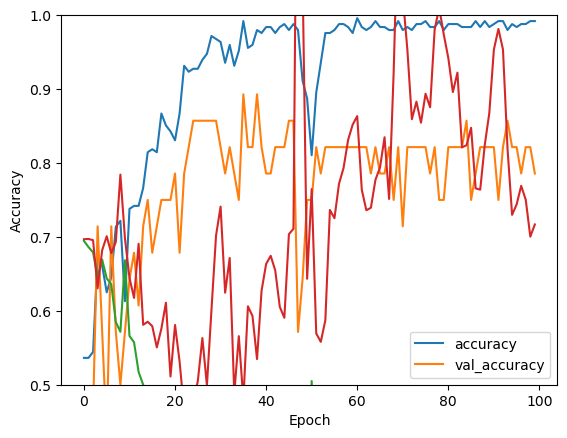

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")

In [21]:
model.save("model.h5")

In [22]:
result = model.evaluate(x=X_calamity,
                         y=y_calamity)

9/9 [==============================] - 1s 144ms/step - loss: 0.0938 - accuracy: 0.9710


In [23]:
_,img_shape, image_shape,_=X_calamity.shape

In [24]:
image_shape=img_shape,img_shape,3
image_shape

(228, 228, 3)

In [141]:
def plot_example(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred !=y_calamity)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_calamity[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_calamity[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[100:109],
                cls_true=cls_true[100:109],
                cls_pred=cls_pred[100:109])

In [142]:
#Predictions
images = X_calamity[50:59]

In [143]:
cls_true =y_calamity[50:59]

In [144]:
y_pred = model.predict(x=images)

1/1 [==============================] - 0s 26ms/step


In [145]:
cls_pred = np.argmax(y_pred, axis=1)

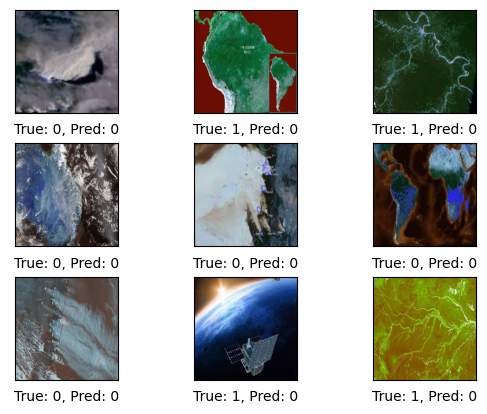

In [146]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

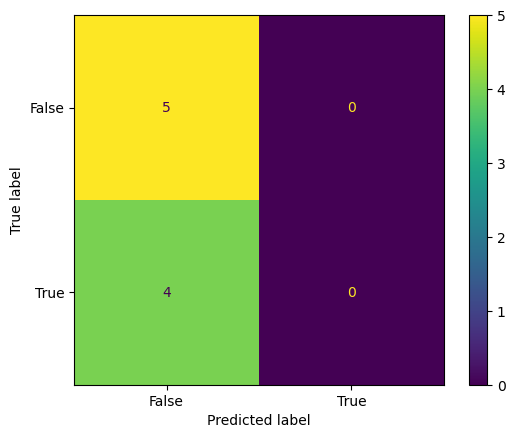

In [147]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = cls_true
predicted = cls_pred

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()